In [1]:
# ! pip install transformers
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchsummary as summary
from tqdm import tqdm

from torch import nn
import torch.nn.functional as F
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig

from sklearn.model_selection import train_test_split
import torch

import pandas as pd
import numpy as np
import os
import base64
import gc
import glob, os

import warnings
warnings.filterwarnings("ignore")

from torch.optim import Adam

C:\Users\hp\miniconda3\envs\tf_gpu\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def create_onedrive_directdownload(onedrive_link):
    data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
    data_bytes64_String = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
    resultUrl = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_String}/root/content"
    return resultUrl

In [3]:
onedrive_link='https://1drv.ms/u/s!AoiE7xOoBAsngsgx2HKIw1RxUnATTg?e=XsxZGD'
onedrive_direct_link=create_onedrive_directdownload(onedrive_link)
onedrive_direct_link
df=pd.read_csv(onedrive_direct_link)
df.drop('Unnamed: 0',axis=1,inplace=True)
df=df[['news_content','rule_labels_comb']]
df=df[~df['rule_labels_comb'].isna()]
df=df[(df['rule_labels_comb'].apply(len)!=2)]
df = df.reset_index()
del df['index']
df

,news_content,rule_labels_comb
0,Berenberg Bank analysts have provided a buy ra...,"['guidelines', 'market']"
1,"The article states that Berenberg, a German in...",['guidelines']
2,"In their analysis on October 30, 2023, experts...","['legal', 'guidelines']"
3,"Berenberg Bank has issued a \""buy\"" recommenda...","['legal', 'guidelines']"
4,The private bank Berenberg has upgraded its ra...,"['legal', 'statements', 'guidelines']"
...,...,...
10320,INTERVIEW Interview with Les Échos Interview w...,"['legal', 'sanctions', 'statements', 'guidelin..."
10321,UBS's latest Investor Watch report reveals tha...,"['legal', 'reports', 'guidelines']"
10322,SNB erwartet für 2021 Jahresgewinn von rund 26...,"['legal', 'reports', 'guidelines']"
10323,0:00 News A cryptocurrency exchange in Hong Ko...,"['legal', 'sanctions', 'reports', 'statements'..."


In [4]:
from ast import literal_eval
df['rule_labels_comb'] = df['rule_labels_comb'].apply(literal_eval)
df['target']='[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]'
df['target'] = df['target'].apply(literal_eval)

df['target'].iloc[0][0]

0.0

In [5]:
for index, value in df['rule_labels_comb'].iteritems():
    class_dic={'legal':0,'sanctions':1,'papers':2,'reports':3,'statements':4,'guidelines':5,'press':6,'personnel':7,'market':8}
    val=[class_dic.get(i, i) for i in value]
    df['rule_labels_comb'].iloc[index]=val
    y=0
    for x in df['rule_labels_comb'].iloc[index]:
        df['target'].iloc[index][x]=1.0
        y=y+1
df['rule_labels_comb']

0                 [5, 8]
1                    [5]
2                 [0, 5]
3                 [0, 5]
4              [0, 4, 5]
              ...       
10320    [0, 1, 4, 5, 8]
10321          [0, 3, 5]
10322          [0, 3, 5]
10323    [0, 1, 3, 4, 5]
10324    [0, 1, 3, 4, 5]
Name: rule_labels_comb, Length: 10325, dtype: object

In [6]:
df['target']

0        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
1        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
2        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
3        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
4        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
                             ...                      
10320    [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0]
10321    [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
10322    [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
10323    [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
10324    [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Name: target, Length: 10325, dtype: object

In [7]:
# import data from gdrive
'''
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/')


df=pd.read_csv('BERT_data.csv')
df=df[~(df['content']=='nan')]
df['content']=df['content'].astype(str)
df['subject']=df['subject'].astype(str)
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nimport os\nos.chdir('/content/drive/My Drive/')\n\n\ndf=pd.read_csv('BERT_data.csv')\ndf=df[~(df['content']=='nan')]\ndf['content']=df['content'].astype(str)\ndf['subject']=df['subject'].astype(str)\n"

In [8]:
# change range of labels, minimum should be zero
df['rule_labels_comb']=df['rule_labels_comb'].astype(str)
df

,news_content,rule_labels_comb,target
0,Berenberg Bank analysts have provided a buy ra...,"[5, 8]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
1,"The article states that Berenberg, a German in...",[5],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"In their analysis on October 30, 2023, experts...","[0, 5]","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
3,"Berenberg Bank has issued a \""buy\"" recommenda...","[0, 5]","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
4,The private bank Berenberg has upgraded its ra...,"[0, 4, 5]","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]"
...,...,...,...
10320,INTERVIEW Interview with Les Échos Interview w...,"[0, 1, 4, 5, 8]","[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0]"
10321,UBS's latest Investor Watch report reveals tha...,"[0, 3, 5]","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
10322,SNB erwartet für 2021 Jahresgewinn von rund 26...,"[0, 3, 5]","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
10323,0:00 News A cryptocurrency exchange in Hong Ko...,"[0, 1, 3, 4, 5]","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]"


In [9]:
# additional filtering to balance classes
'''
df_3=df[(df['result']==3) & (df['content'].str.len()<350)]
df=df[~(df['result']==3)]
df=pd.concat([df,df_3])
df
'''

"\ndf_3=df[(df['result']==3) & (df['content'].str.len()<350)]\ndf=df[~(df['result']==3)]\ndf=pd.concat([df,df_3])\ndf\n"

In [10]:
# import BERT tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
class Dataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.labels=df['target']
        self.text=[tokenizer(text,padding='max_length',max_length=512,truncation=True,return_tensors="pt") for text in df['news_content']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.text[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [11]:
# train test split
X_train, X_test= train_test_split(df[['news_content','target']], test_size=0.25)

In [12]:
df_train=X_train
df_val=X_test
df_test=0

In [13]:
df_train

,news_content,target
6475,Can Japan become a global leader in green stee...,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
6419,Nun hat Thomas Schaufler also der Privatkunden...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2898,The article from finanz-szene.de discusses the...,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]"
4104,Berenberg Bank set a target price of 1530 GBX ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
7604,Heute findet die proutatwork Konferenz in unse...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...
4677,Unser Robot zum DAX: Starker Donnerstag Commer...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3400,The Swiss National Bank (SNB) announced that i...,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]"
5623,Auch wegen drohender RatingHerabstufungen hätt...,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]"
886,<br>1. Gebrüder Bethmann bank was established ...,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]"


In [14]:
# XLNet classifier architecture, with 7 output classes
class XLNetClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(XLNetClassifier, self).__init__()
        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased', return_dict=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.xlnet.config.hidden_size, 9)
        torch.nn.init.kaiming_uniform_(self.linear.weight, nonlinearity='relu')
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):

        outputs = self.xlnet(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Get the CLS token representation
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer


In [15]:
# change runtype to GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [16]:
# hyperparameters
EPOCHS = 22
model = XLNetClassifier()
LR = 0.0001

In [17]:
df_train=df_train.reset_index()
df_train.drop('index',axis=1,inplace=True)

df_val=df_val.reset_index()
df_val.drop('index',axis=1,inplace=True)
df_val

,news_content,target
0,Gerade dadurch unterstützt er beim Abwägen von...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
1,Economists at Berenberg Bank predict consumers...,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,The article discusses Congress Asset Managemen...,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]"
3,UBS berichtet heute über die Ergebnisse des vi...,"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]"
4,Seit seiner Gründung ist UBS PremiumPartnerin ...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...
2577,Berenberg Gossler & Co. KG (Berenberg Bank). 1...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2578,UBS's wealth management division reported almo...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2579,RT boersefrankfurt: Gen Souterrain. Erhebung d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2580,"<br>1. The financial technology company, Squar...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"


In [18]:
# display XLNet layers
n=0
for x in model.state_dict():
    n=n+1
    print(x)
n

xlnet.mask_emb
xlnet.word_embedding.weight
xlnet.layer.0.rel_attn.q
xlnet.layer.0.rel_attn.k
xlnet.layer.0.rel_attn.v
xlnet.layer.0.rel_attn.o
xlnet.layer.0.rel_attn.r
xlnet.layer.0.rel_attn.r_r_bias
xlnet.layer.0.rel_attn.r_s_bias
xlnet.layer.0.rel_attn.r_w_bias
xlnet.layer.0.rel_attn.seg_embed
xlnet.layer.0.rel_attn.layer_norm.weight
xlnet.layer.0.rel_attn.layer_norm.bias
xlnet.layer.0.ff.layer_norm.weight
xlnet.layer.0.ff.layer_norm.bias
xlnet.layer.0.ff.layer_1.weight
xlnet.layer.0.ff.layer_1.bias
xlnet.layer.0.ff.layer_2.weight
xlnet.layer.0.ff.layer_2.bias
xlnet.layer.1.rel_attn.q
xlnet.layer.1.rel_attn.k
xlnet.layer.1.rel_attn.v
xlnet.layer.1.rel_attn.o
xlnet.layer.1.rel_attn.r
xlnet.layer.1.rel_attn.r_r_bias
xlnet.layer.1.rel_attn.r_s_bias
xlnet.layer.1.rel_attn.r_w_bias
xlnet.layer.1.rel_attn.seg_embed
xlnet.layer.1.rel_attn.layer_norm.weight
xlnet.layer.1.rel_attn.layer_norm.bias
xlnet.layer.1.ff.layer_norm.weight
xlnet.layer.1.ff.layer_norm.bias
xlnet.layer.1.ff.layer_1.weig

208

In [19]:
# freeze first 8 layers 
n=0
for param in model.parameters():
    n=n+1
    param.requires_grad = False
    if n==(201-68):
        break

In [20]:
# change datatypes of input data
df_train['news_content']=df_train['news_content'].astype(str)

df_val['news_content']=df_val['news_content'].astype(str)
df_train['news_content'].iloc[0]

'Can Japan become a global leader in green steel? # UBSResearch looks at Japanese steel mills’ differentiated branding strategies which are characterized by highperformance ecoproducts using green steel processes. #shareUBS'

In [22]:
torch.cuda.empty_cache()
gc.collect()

0

Epoch 1/22: 100%|███████████████████████████████████████████████████████| 259/259 [1:45:24<00:00, 24.42s/item, Epoch=1]


Epoch 2/22: 100%|███████████████████████████████████████████████████████| 259/259 [1:40:41<00:00, 23.33s/item, Epoch=2]


Epoch 3/22: 100%|███████████████████████████████████████████████████████| 259/259 [1:40:39<00:00, 23.32s/item, Epoch=3]


Epoch 4/22: 100%|███████████████████████████████████████████████████████| 259/259 [2:26:38<00:00, 33.97s/item, Epoch=4]


Epoch 5/22: 100%|███████████████████████████████████████████████████████| 259/259 [1:46:10<00:00, 24.60s/item, Epoch=5]


Epoch 6/22: 100%|███████████████████████████████████████████████████████| 259/259 [1:40:38<00:00, 23.31s/item, Epoch=6]


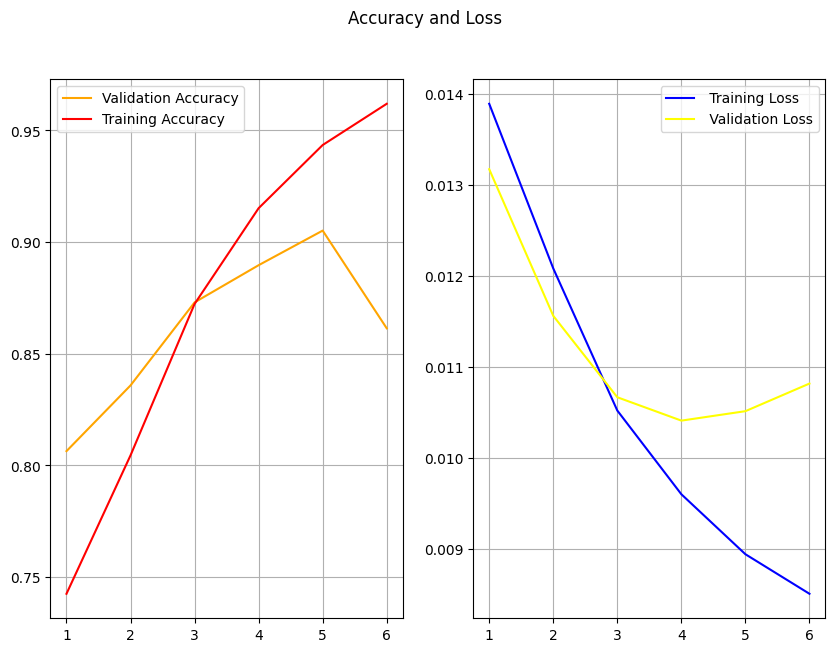

In [23]:
def train(model, train_data, val_data, learning_rate, epochs):
    
    stop_criteria=0
    
    train, val = Dataset(train_data), Dataset(val_data)
    
    # mini batching
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=30)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=30)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    
    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()
            
    plot_val_acc=[]
    plot_train_acc=[]
    plot_epoch=[]
    plot_train_loss=[]
    plot_val_loss=[]

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
            true_acc=0
            n=0
            with tqdm(total=len(train_dataloader), desc=f'Epoch {epoch_num + 1}/{epochs}', unit='item',position=0,leave=True) as p_bar:
                for train_input, train_label in train_dataloader:
                    train_label = train_label.to(device) # to cuda GPU
                    mask = train_input['attention_mask'].squeeze(1).to(device) # attention mask
                    input_id = train_input['input_ids'].squeeze(1).to(device)

                    l1_loss=0

                    # for L1 regularization
                    a=0
                    reg_loss = 0
                    for param in model.parameters():
                        a=a+1
                        if a >=201-68:
                            reg_loss += torch.norm(param, 1) 
                    '''
                    factor = 0.00001 #lambda for L1 regularization
                    l1_loss=factor * reg_loss # L1 loss
                    '''
                    # model output
                    output = model(input_id, mask)


                    # loss value
                    batch_loss = criterion(output, train_label) + l1_loss
                    total_loss_train += batch_loss.item() 

                    # train accuracy 
                    output=output.squeeze(0)
                    train_label=train_label.squeeze(0)
                    # print(output)
                    # print(train_label)
                    # print(torch.gather(train_label, 1, torch.argmax(output,dim=1).view(-1, 1)))
                    acc = torch.gather(train_label, 1, torch.argmax(output,dim=1).view(-1, 1)).sum().item()
                    total_acc_train += acc
                    
                    # true accuracy
                    true_acc_batch=0
                    for (x,y) in zip(torch.round(F.sigmoid(output)*10)/10,train_label): # ceil or round
                        x=torch.tensor(x)
                        y=torch.tensor(y)
                        # print(x)
                        # print(y)
                        x[x<1]=0
                        true_acc=true_acc+torch.sum(x==y).item()
                        true_acc_batch=true_acc_batch+torch.sum(x==y).item()

                    # backpropogation
                    model.zero_grad()
                    batch_loss.backward()
                    optimizer.step()
                    p_bar.set_postfix(loss=batch_loss.item() / len(train_input['input_ids']), acc=acc / len(train_input['input_ids']), true_acc=true_acc_batch / (len(train_input['input_ids'])*9))
                    p_bar.update()
                p_bar.set_postfix({'Epoch': epoch_num + 1})

            total_acc_val = 0
            total_loss_val = 0
            true_val_acc=0
            
            # for validation accuracy
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].squeeze(1).to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)
                    
                    # validation output
                    output = model(input_id, mask)
                    
                    # validation loss value
                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                
                    # validation accuracy
                    output=output.squeeze(0)
                    val_label=val_label.squeeze(0)
                    acc = torch.gather(val_label, 1, torch.argmax(output,dim=1).view(-1, 1)).sum().item()
                    total_acc_val += acc
                    
                    # true accuracy
                    for (x,y) in zip(torch.round(F.sigmoid(output)*10)/10,val_label): # ceil or round
                        x=torch.tensor(x)
                        y=torch.tensor(y)
                        x[x<1]=0
                        true_val_acc=true_val_acc+torch.sum(x==y).item()

            print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f} \
            | True Train Accuracy: {true_acc / (len(train_data)*9): .3f} \
            | True Val Accuracy: {true_val_acc / (len(val_data)*9): .3f}',end='\r')
            
            plot_train_acc.append(total_acc_train / len(train_data))
            plot_val_acc.append(total_acc_val / len(val_data))
            plot_epoch.append(epoch_num + 1)
            plot_train_loss.append(total_loss_train / (len(train_data)*9))
            plot_val_loss.append(total_loss_val / (len(val_data)*9))
            
            # model checkpoint
            checkpoint = {
            'epoch': epoch_num+1,
            'model_state_dict': model.state_dict(),
            }
            
            torch.save(checkpoint, f'XLNet_checkpoint_epoch{epoch_num+1}.pth')
            
            try:
                if plot_val_loss[-1]>plot_val_loss[-2] and plot_val_loss[-2]>plot_val_loss[-3]:
                    break
            except:
                pass
            
            
    fig, ax = fig,ax= plt.subplots(1, 2, figsize=(10, 7))
    fig.suptitle('Accuracy and Loss')
    
    
    
    ax[0].plot(plot_epoch,plot_val_acc, label='Validation Accuracy',color='orange')
    ax[0].plot(plot_epoch,plot_train_acc, label='Training Accuracy',color='red')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].plot(plot_epoch,plot_train_loss, label=' Training Loss',color='blue')
    ax[1].plot(plot_epoch,plot_val_loss, label=' Validation Loss',color='yellow')
    ax[1].legend()
    ax[1].grid(True)
    
    plt.show()
    
    # retrieve best checkpoint model
    checkpoint = torch.load(f'XLNet_checkpoint_epoch{epoch_num+1-2}.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    
    # save best model
    torch.save(model, 'XLNet_classifier.pth')
    
    # delete remaining model checkpoints
    for f in glob.glob("XLNet_checkpoint*.pth"):
        os.remove(f)  
        
        
train(model, df_train, df_val, LR, EPOCHS)